<a href="https://colab.research.google.com/github/jpscard/DataH_Internship/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DataH Internship Program 2024-2025**

# **Alunos:**
## - João Paulo Cardoso.
## - Leonardo Alves Pereira.
## - Rosemeri Borges.

# **Desafio 3 - Projeto de Classificação de Candlesticks**

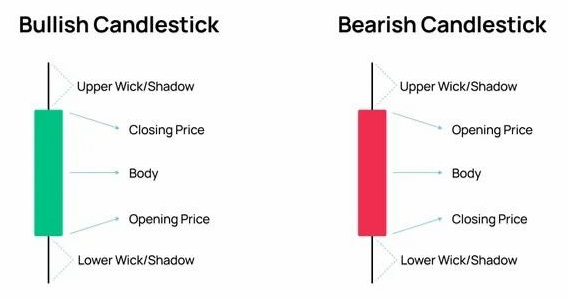


## **1. Introdução**


Este projeto visa a classificação automática de candlesticks utilizando técnicas de aprendizado não supervisionado. Os candlesticks são amplamente utilizados em análises de mercado financeiro para identificar tendências e reversões. Nosso objetivo é identificar padrões similares em candles por meio de algoritmos de clusterização, visualizando os resultados por meio de gráficos interativos e verificando a eficácia dos clusters com métricas de avaliação como o Silhouette Score.



## **2. Objetivo**

* Classificar automaticamente candlesticks com base em características como corpo, sombra superior e inferior.
* Avaliar a eficiência dos clusters formados utilizando métodos quantitativos e visuais, como gráficos 2D, 3D e gráficos de candlestick interativos.
* Aplicar técnicas de validação como o Método Elbow e o Silhouette Score para determinar o número ideal de clusters.
* Explorar a viabilidade de automatizar a identificação de padrões para auxiliar traders na tomada de decisões.



## **3. Implementação**

### **3.1 Instalação e importação das bibliotecas**

In [1]:
## Instalar pacote necessário
!pip install --quiet sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 33.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
import sweetviz
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### **3.2 Preparação dos dados**

In [3]:
# Baixar e carregar o dataset no dataframe
url = 'https://docs.google.com/spreadsheets/d/1mp8oSZjKtJcURz3O5v0Dp5a3LODKR8bGrgpmrQxVksg/export?format=csv'
df = pd.read_csv(url)

In [4]:
# Limpar valores ausentes
df.dropna(inplace=True)

In [5]:
# Exibir as primeiras linhas
df.head()

,Date,Open,High,Low,Close
0,2022-06-03,200.139999,202.949997,198.050003,198.979996
1,2022-06-02,192.020004,205.470001,191.720001,205.089996
2,2022-06-01,198.699997,202.740005,191.660004,192.910004
3,2022-05-31,196.179993,199.949997,190.800003,197.440002
4,2022-05-27,193.190002,195.250000,190.369995,195.190002


### **3.3 Análise Exploratória (EDA)**



In [6]:
# Descrição geral do dataset
df.info()  # Verificar tipos de dados e valores nulos
df.describe()  # Estatísticas descritivas para as colunas numéricas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5044 non-null   object 
 1   Open    5044 non-null   float64
 2   High    5044 non-null   float64
 3   Low     5044 non-null   float64
 4   Close   5044 non-null   float64
dtypes: float64(4), object(1)
memory usage: 197.2+ KB


,Open,High,Low,Close
count,5044.000000,5044.000000,5044.000000,5044.000000
mean,116.467981,118.237392,114.578719,116.456338
std,168.740876,171.140864,166.119837,168.668232
min,0.377857,0.410714,0.346429,0.372857
25%,3.955357,4.031072,3.885357,3.958571
50%,25.819285,26.342143,25.455000,25.802856
75%,155.762497,157.654998,153.944996,155.869999
max,692.349976,700.989990,686.090027,691.690002


                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



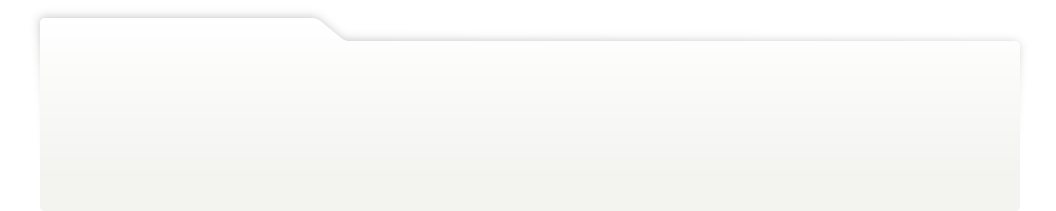
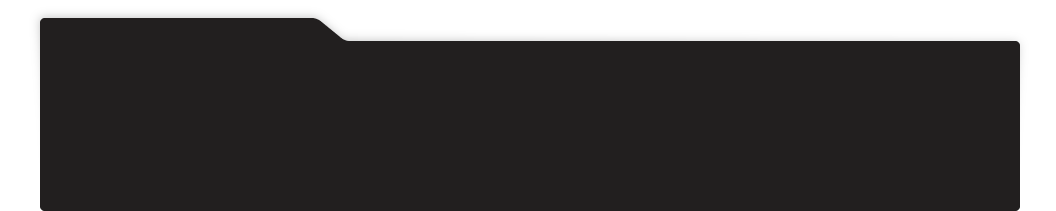
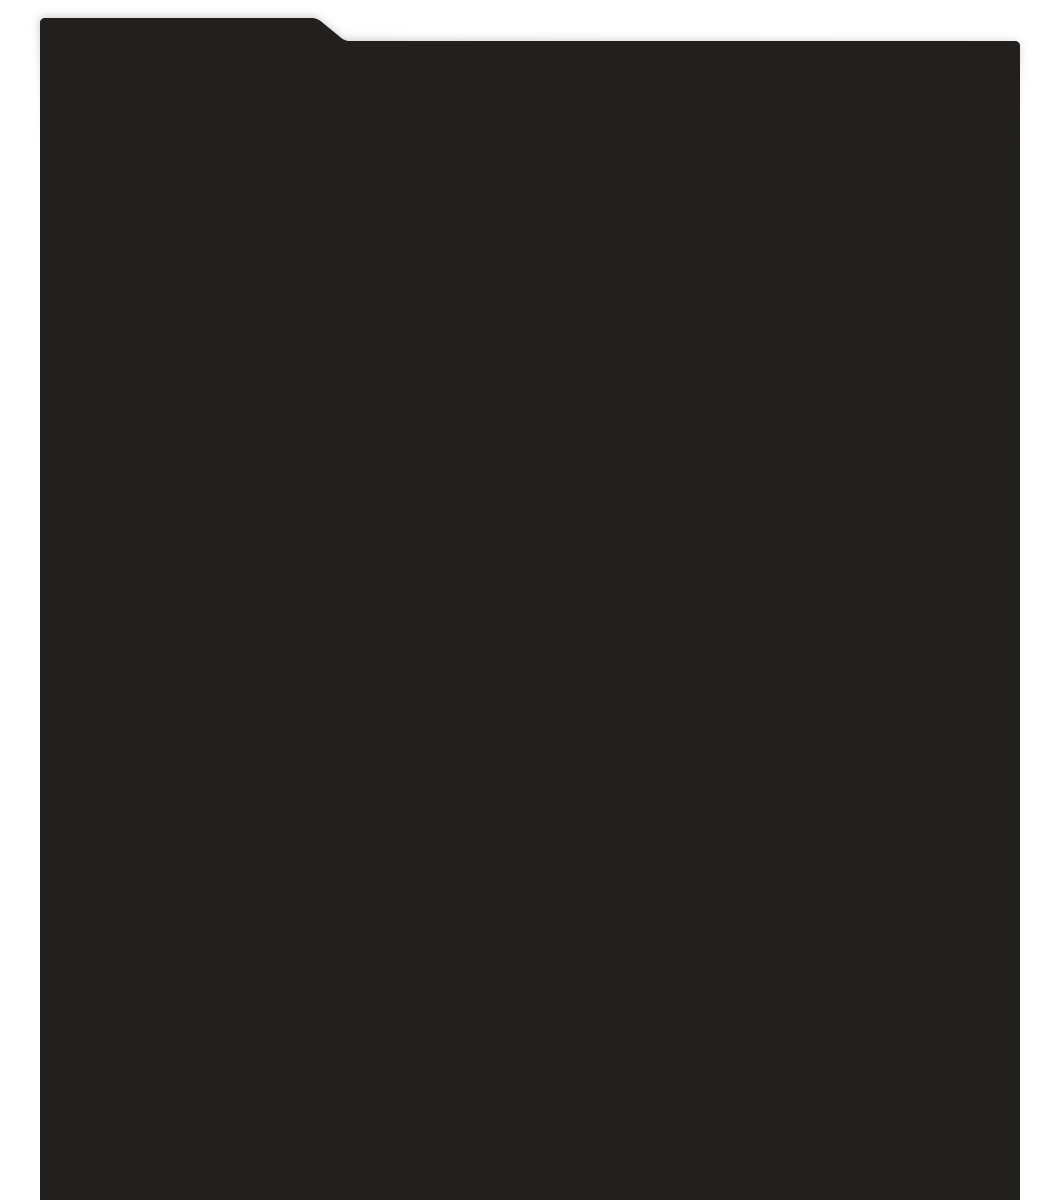
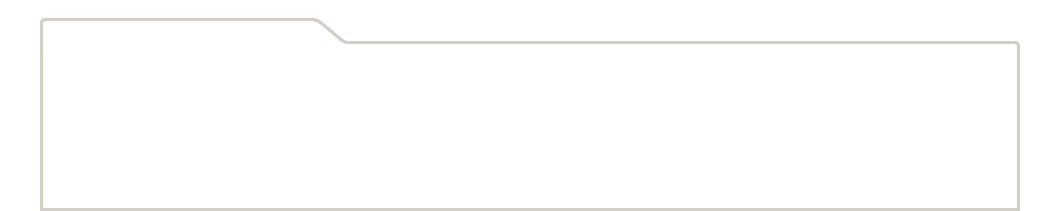
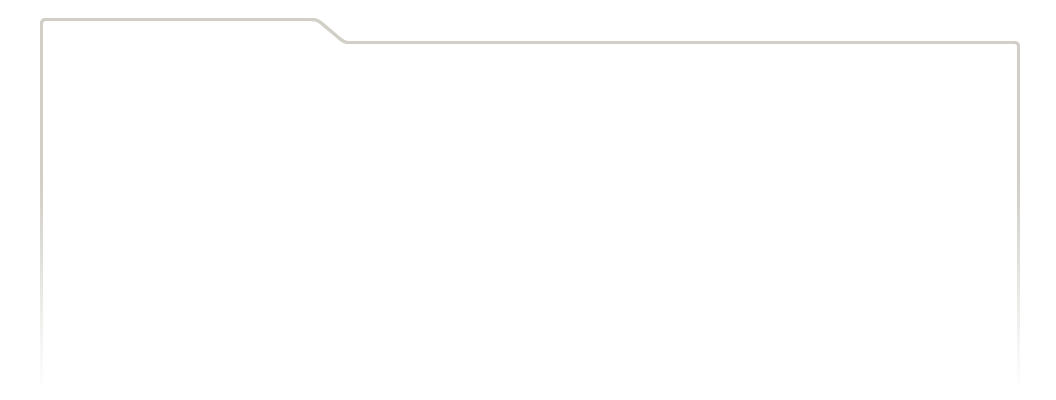
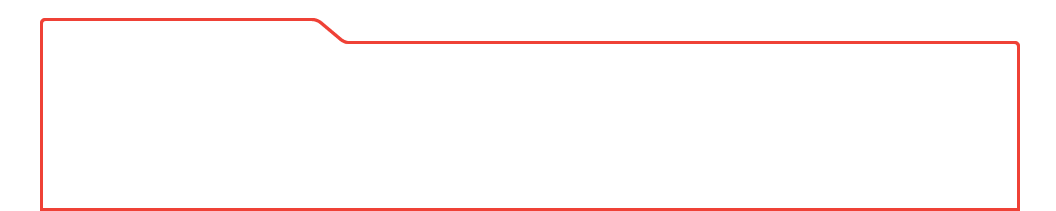
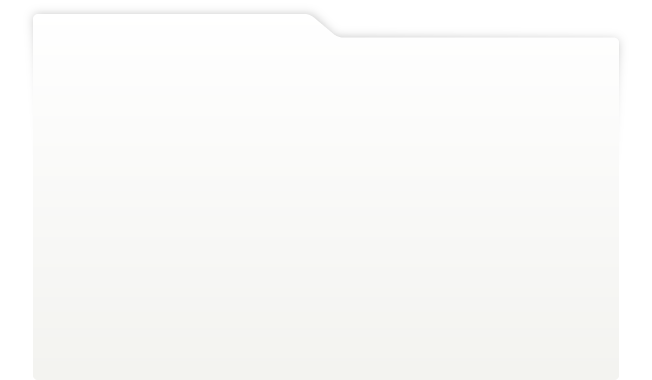
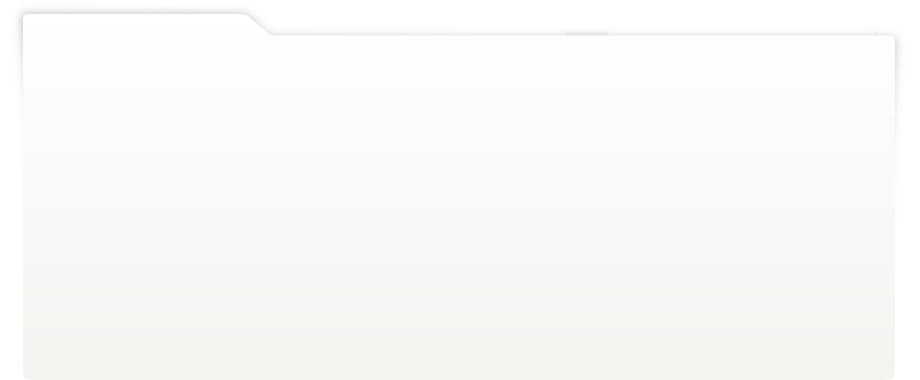
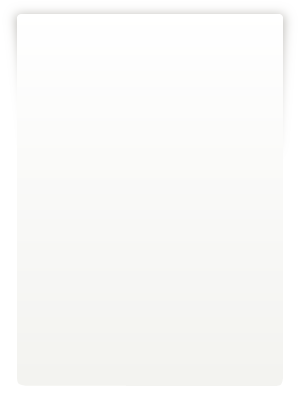
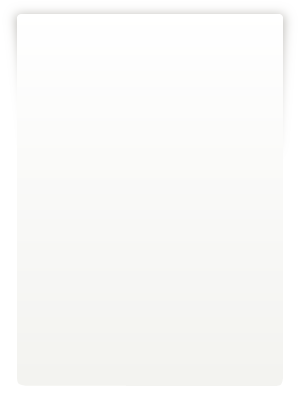
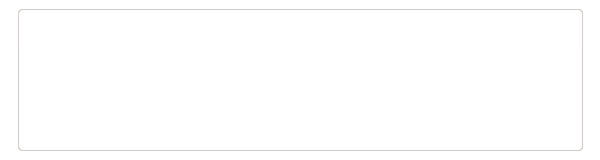
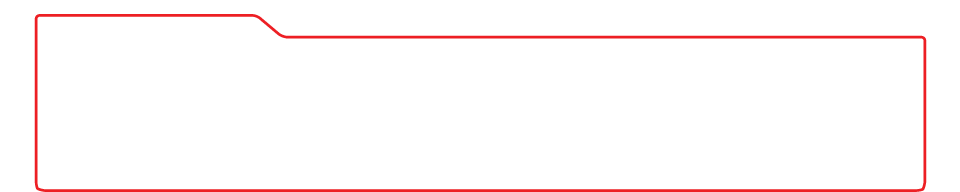
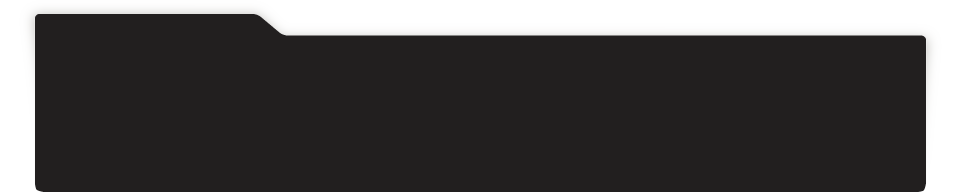
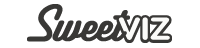
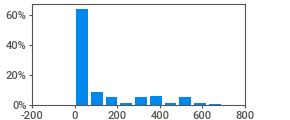
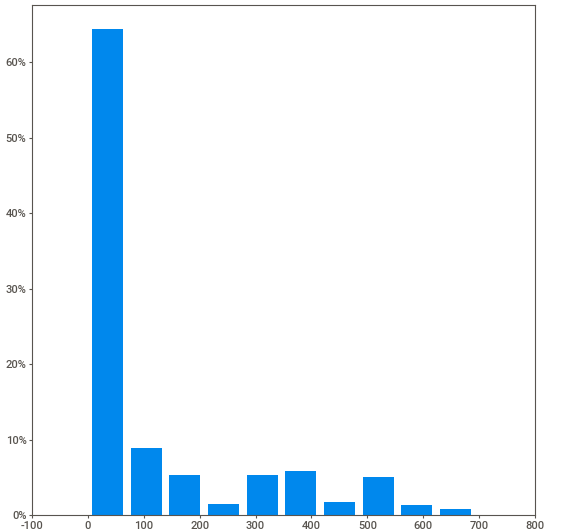
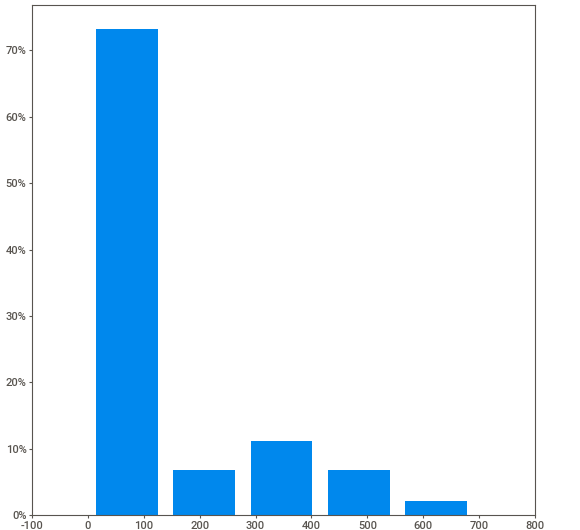
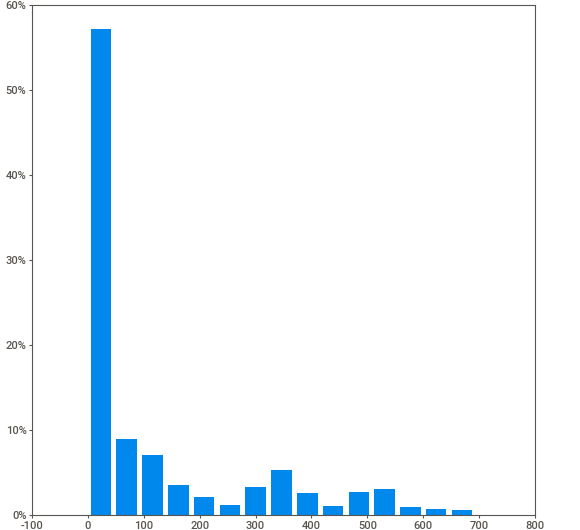
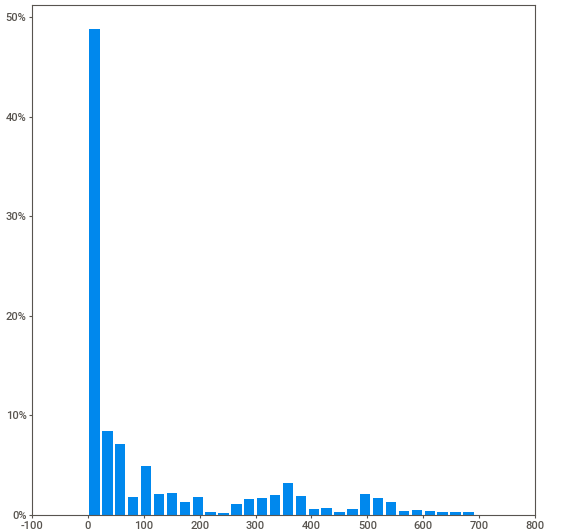
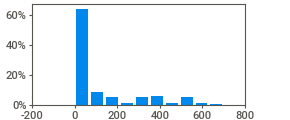
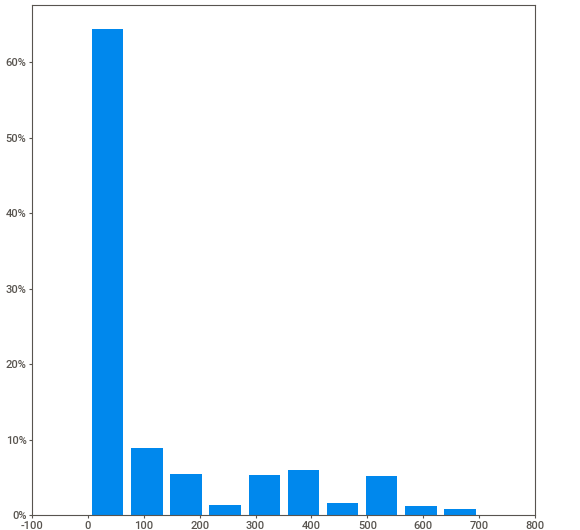
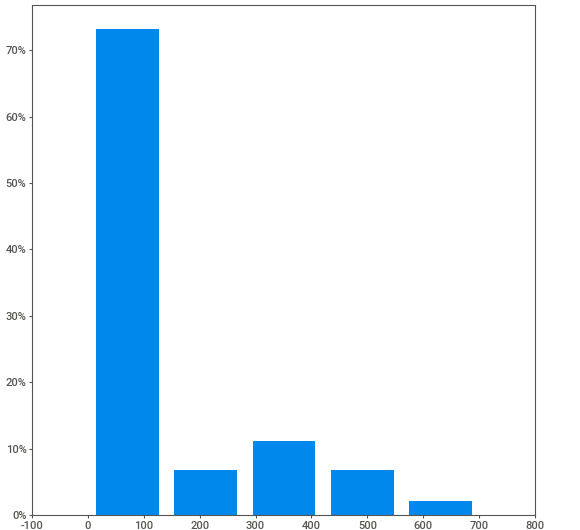
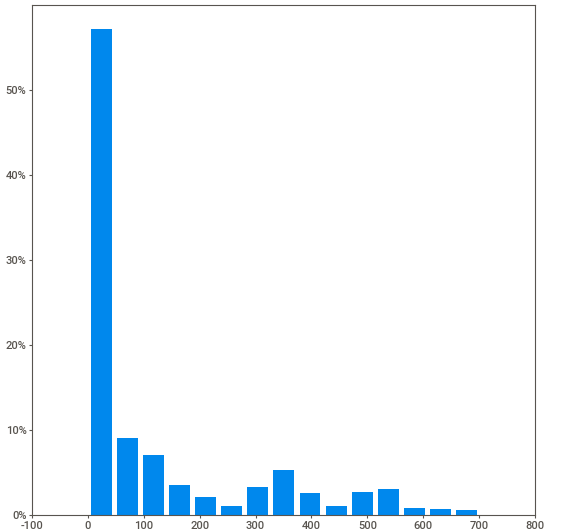
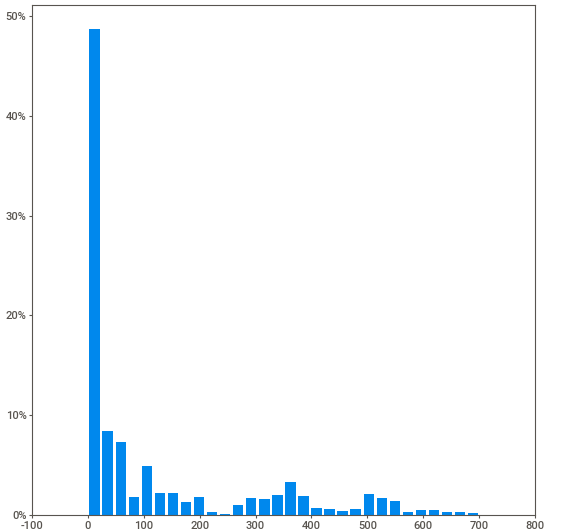
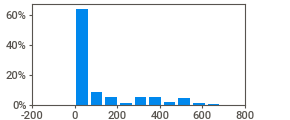
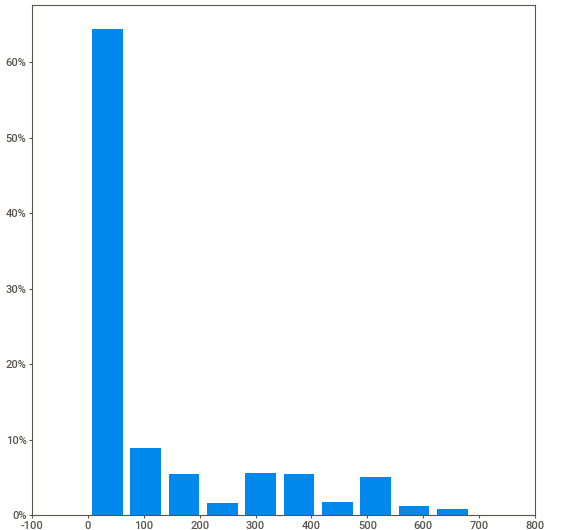
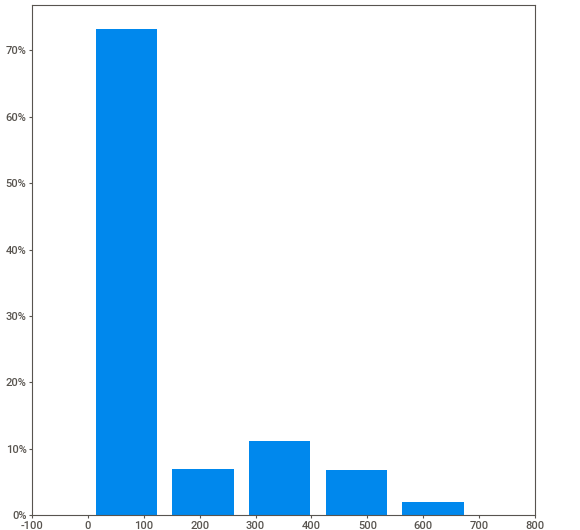
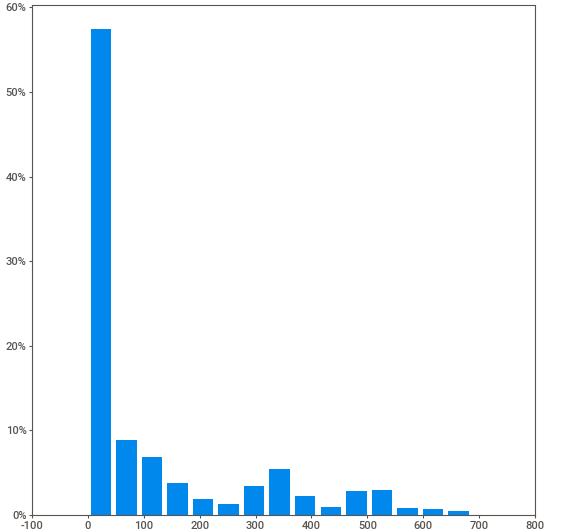
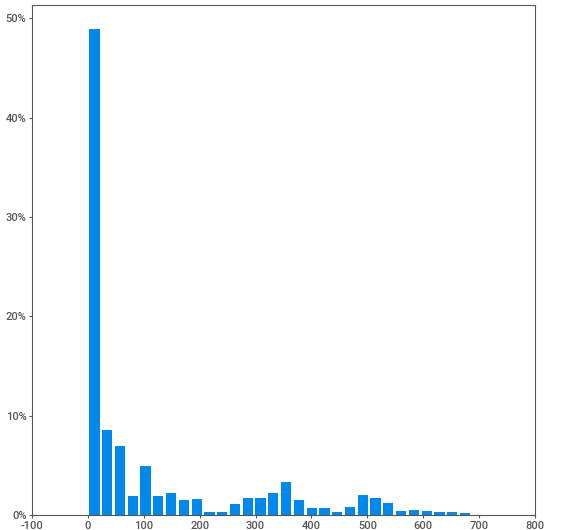
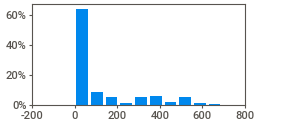
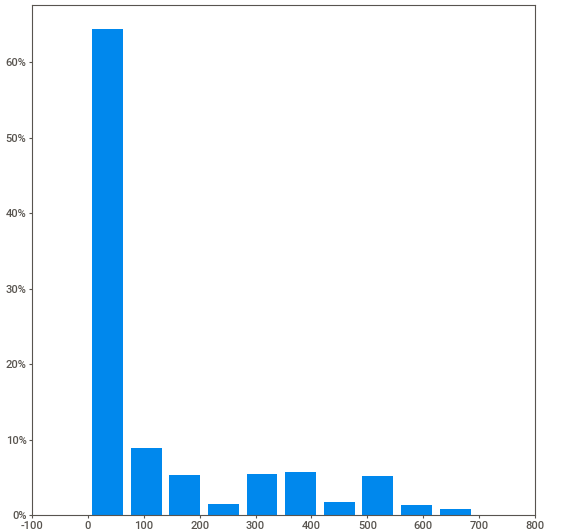
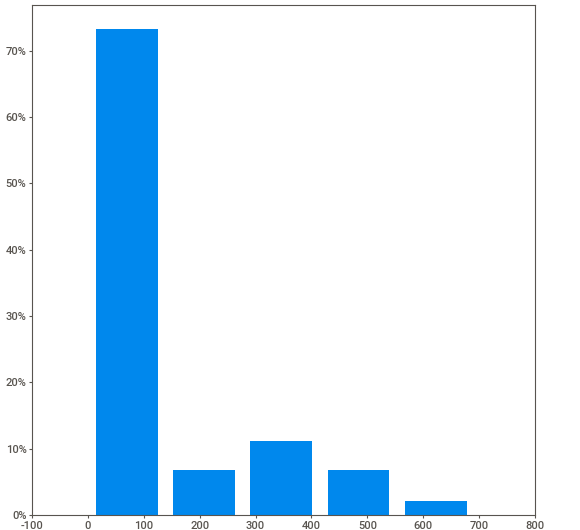
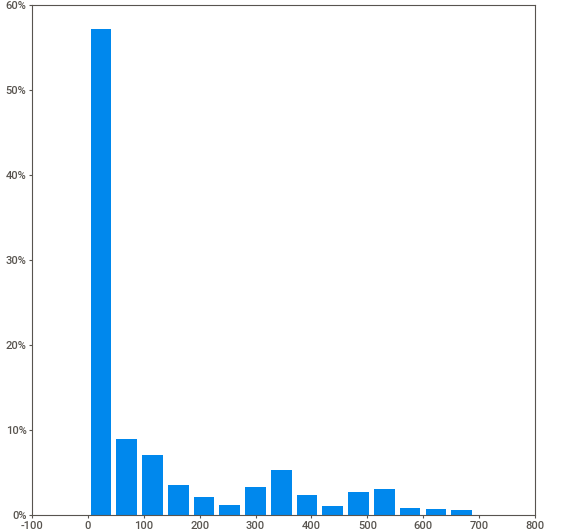
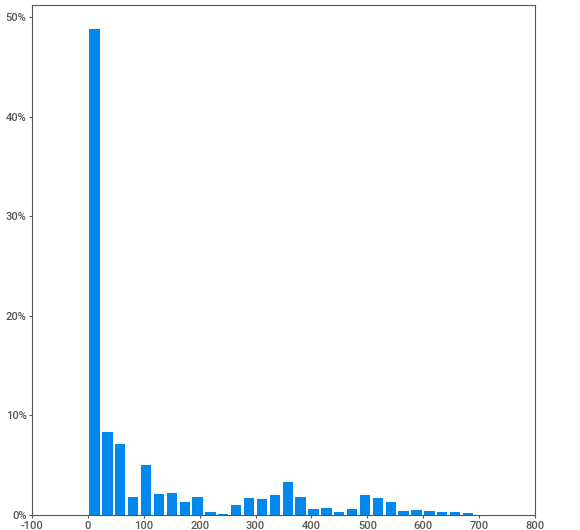
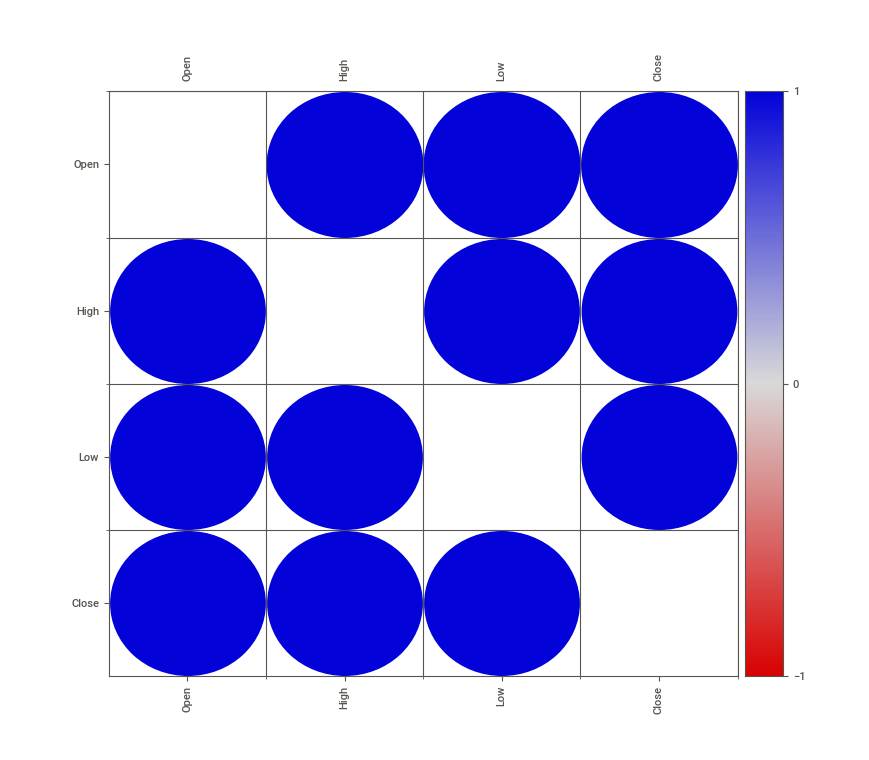
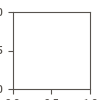

In [7]:
## Analisar os dados com SweetViz
df_sv = sweetviz.analyze(df)
df_sv.show_html()

## Ler o conteúdo do arquivo HTML
with open('SWEETVIZ_REPORT.html', 'r') as f:
   conteudo_html = f.read()

## Exibir o conteúdo HTML
display(HTML(conteudo_html))

### **3.4 Extração de Características**

Com base nos nomes das colunas (Open, High, Low, Close), vamos calcular as características como corpo, sombra superior, sombra inferior, tamanho total, e razão corpo/sombra.

In [8]:
# Cálculo das características dos candlesticks
df['corpo'] = abs(df['Close'] - df['Open'])
df['sombra_superior'] = df['High'] - df[['Close', 'Open']].max(axis=1)
df['sombra_inferior'] = df[['Close', 'Open']].min(axis=1) - df['Low']
df['tamanho_total'] = df['High'] - df['Low']  # Variação total do candle
df['razao_corpo_sombra'] = df['corpo'] / (df['sombra_superior'] + df['sombra_inferior'] + 1e-6)

# 1. Calcular corpo, sombra superior e sombra inferior
df['corpo'] = np.abs(df['Open'] - df['Close'])
df['sombra_superior'] = df['High'] - np.maximum(df['Open'], df['Close'])
df['sombra_inferior'] = np.minimum(df['Open'], df['Close']) - df['Low']

# Determinar a direção do candle (Bullish = 1, Bearish = 0)
df['direcao'] = np.where(df['Close'] > df['Open'], 1, 0)

# Calcular a participação em % de cada parte (Body, Upper_Shadow, Lower_Shadow)
df['Total_Range'] = df['High'] - df['Low']
df['corpo_%'] = (df['corpo'] / df['Total_Range']) * 100
df['sombra_superior_%'] = (df['sombra_superior'] / df['Total_Range']) * 100
df['sombra_inferior_%'] = (df['sombra_inferior'] / df['Total_Range']) * 100

# Exibir as novas colunas
df[['Date', 'corpo', 'sombra_superior', 'sombra_inferior', 'tamanho_total', 'razao_corpo_sombra', 'corpo_%', 'sombra_superior_%', 'sombra_inferior_%','direcao']].head()


,Date,corpo,sombra_superior,sombra_inferior,tamanho_total,razao_corpo_sombra,corpo_%,sombra_superior_%,sombra_inferior_%,direcao
0,2022-06-03,1.160003,2.809998,0.929993,4.899994,0.310162,23.673560,57.346968,18.979472,0
1,2022-06-02,13.069992,0.380005,0.300003,13.750000,19.220322,95.054487,2.763673,2.181840,1
2,2022-06-01,5.789993,4.040008,1.250000,11.080001,1.094515,52.256250,36.462163,11.281587,0
3,2022-05-31,1.260009,2.509995,5.379990,9.149994,0.159697,13.770599,27.431657,58.797743,1
4,2022-05-27,2.000000,0.059998,2.820007,4.880005,0.694443,40.983565,1.229466,57.786969,1


In [9]:
# Apresentar estatísticas descritivas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5044.0,116.467981,168.740876,0.377857,3.955357,25.819285,155.762497,692.349976
High,5044.0,118.237392,171.140864,0.410714,4.031072,26.342143,157.654998,700.989990
Low,5044.0,114.578719,166.119837,0.346429,3.885357,25.455000,153.944996,686.090027
Close,5044.0,116.456338,168.668232,0.372857,3.958571,25.802856,155.869999,691.690002
corpo,5044.0,1.814612,3.754904,0.000000,0.065715,0.285000,1.574646,55.030029
sombra_superior,5044.0,0.867927,1.823665,0.000000,0.029999,0.129993,0.740000,27.720001
sombra_inferior,5044.0,0.976134,2.046647,0.000000,0.030000,0.141430,0.887856,32.450013
tamanho_total,5044.0,3.658673,5.978758,0.006428,0.165714,0.873571,4.389999,56.959991
razao_corpo_sombra,5044.0,35.832910,1864.292135,0.000000,0.326637,0.894350,2.067043,127143.000000
direcao,5044.0,0.488501,0.499917,0.000000,0.000000,0.000000,1.000000,1.000000


### **3.5 Normalização e PCA**

Vamos normalizar as características extraídas para que fiquem na mesma escala.

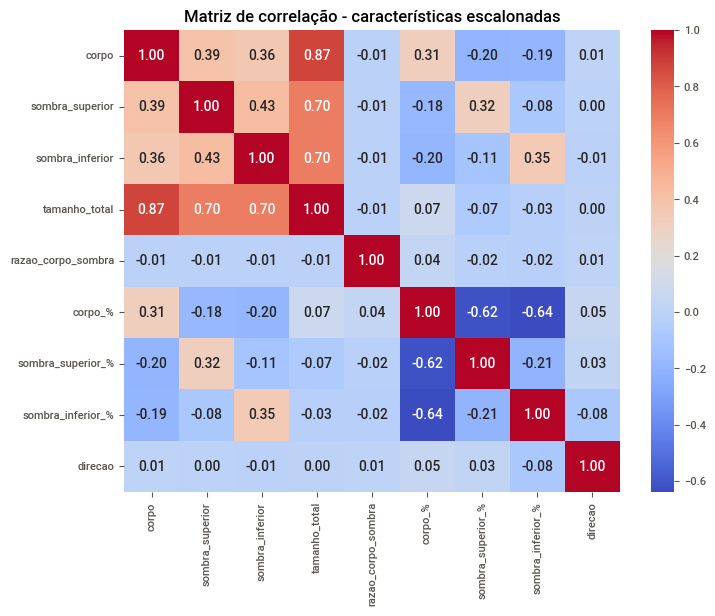

In [12]:
# Selecionar as características e normalizar
features = df[['corpo', 'sombra_superior', 'sombra_inferior', 'tamanho_total', 'razao_corpo_sombra', 'corpo_%', 'sombra_superior_%', 'sombra_inferior_%','direcao']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Criar um DataFrame com os dados escalonados
features_scaled_df = pd.DataFrame(features_scaled, columns=['corpo', 'sombra_superior', 'sombra_inferior', 'tamanho_total', 'razao_corpo_sombra', 'corpo_%', 'sombra_superior_%', 'sombra_inferior_%','direcao'])

correlation_matrix_fsdf = features_scaled_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_fsdf, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlação - características escalonadas')
plt.show()

Agora aplicamos a Análise de Componentes Principais (PCA) para reduzir a dimensionalidade para 2 componentes.

<ipython-input-13-35ffd56d05b6>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], palette='viridis')


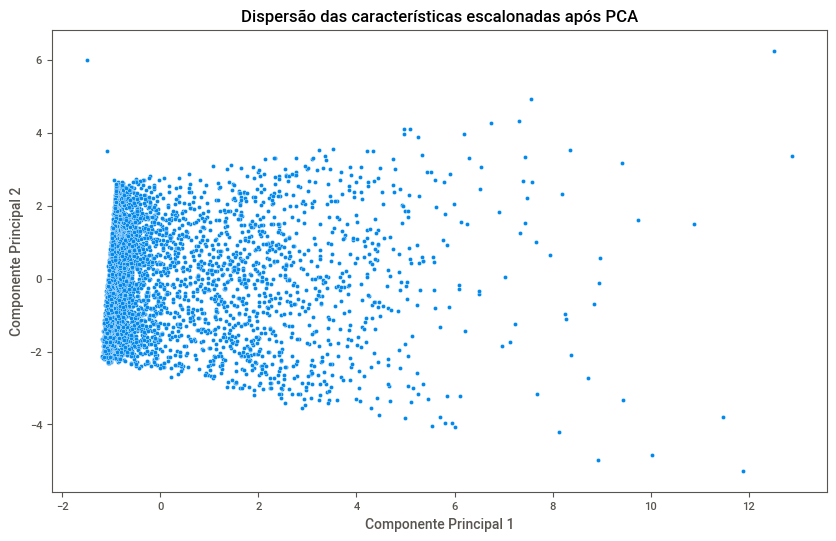

In [13]:
# Reduzir a dimensionalidade usando PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Gráfico de dispersão após PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], palette='viridis')
plt.title('Dispersão das características escalonadas após PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

### **4. Avaliação do Modelo**

### **4.1 Método Elbow e Silhouette Score para Identificação de Clusters**

Utilizamos o Método Elbow e o Silhouette Score para determinar o número ideal de clusters.

Silhouette Score for 2 clusters: 0.3754
Silhouette Score for 3 clusters: 0.4650
Silhouette Score for 4 clusters: 0.4838
Silhouette Score for 5 clusters: 0.4940
Silhouette Score for 6 clusters: 0.4370
Silhouette Score for 7 clusters: 0.4411
Silhouette Score for 8 clusters: 0.4013
Silhouette Score for 9 clusters: 0.4074
Silhouette Score for 10 clusters: 0.3733


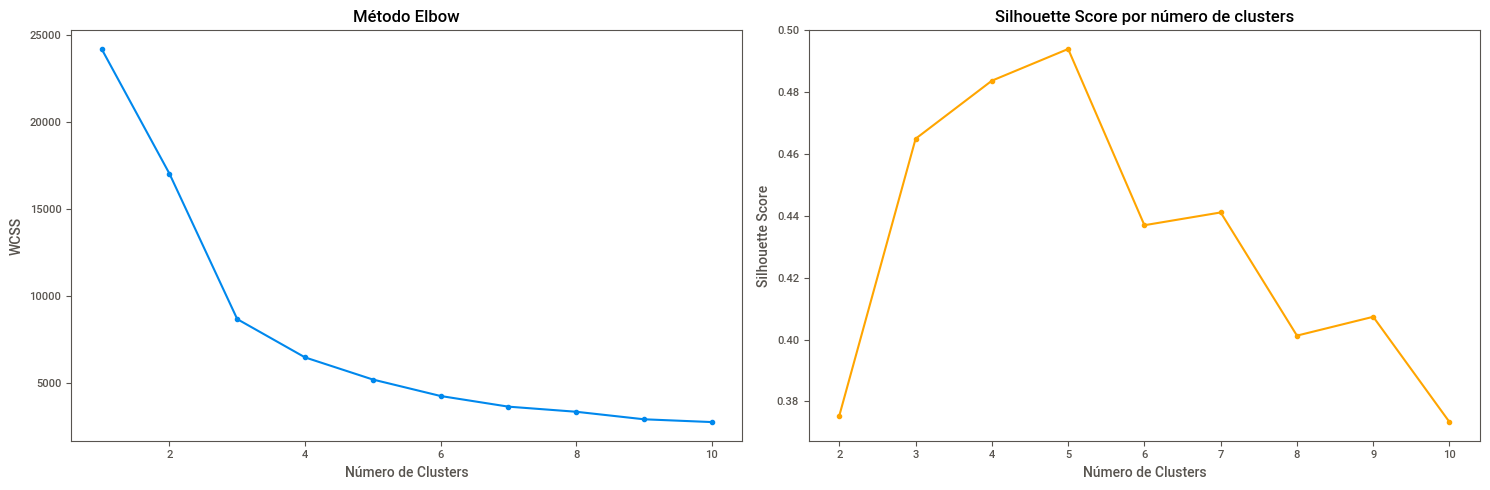

In [14]:
wcss = []
silhouette_scores = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(features_pca)
    wcss.append(kmeans.inertia_)

    if i > 1:  # O Silhouette Score só pode ser calculado para mais de 1 cluster
        silhouette_avg = silhouette_score(features_pca, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'Silhouette Score for {i} clusters: {silhouette_avg:.4f}')

# Gráficos Elbow e Silhouette Score
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Método Elbow
axs[0].plot(range(1, 11), wcss, marker='o')
axs[0].set_title('Método Elbow')
axs[0].set_xlabel('Número de Clusters')
axs[0].set_ylabel('WCSS')

# Silhouette Score
axs[1].plot(range(2, 11), silhouette_scores, marker='o', color='orange')
axs[1].set_title('Silhouette Score por número de clusters')
axs[1].set_xlabel('Número de Clusters')
axs[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


### **4.2 Validação e Visualização dos Clusters com Candlesticks**

**Visualização de Candlesticks Classificados**

Agora exibimos os candlesticks classificados, com as classes representadas por diferentes cores.

In [15]:
import plotly.graph_objects as go

# Aplicar K-Means com o número ideal de clusters
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Candle_Type'] = kmeans.fit_predict(features_pca)

# Gráfico interativo de candlestick com classificação
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                                       open=df['Open'],
                                       high=df['High'],
                                       low=df['Low'],
                                       close=df['Close'],
                                       name='Candlestick')])

# Cores para os clusters
colors = sns.color_palette("husl", n_colors=optimal_clusters)

# Adicionar os clusters sobre os candlesticks
for i in range(len(df)):
    fig.add_trace(go.Scatter(
        x=[df['Date'][i]],
        y=[df['High'][i] + 2],
        mode='markers',
        marker=dict(color=colors[df['Candle_Type'][i]], size=10),
        showlegend=False,
        hoverinfo='text',
        text=f'Tipo: {df["Candle_Type"][i]}'
    ))

# Adicionar legenda para cada tipo de candlestick
for candle_type in range(optimal_clusters):
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(color=colors[candle_type], size=10),
        name=f'Tipo {candle_type}'
    ))

fig.update_layout(title='Candlesticks classificados',
                  xaxis_title='Data',
                  yaxis_title='Preço',
                  xaxis_rangeslider_visible=False)

fig.show()


### **4.3 Gráfico de Dispersão 2D**

Vamos visualizar os clusters em um gráfico de dispersão 2D para verificar a separação entre os tipos de candlesticks.

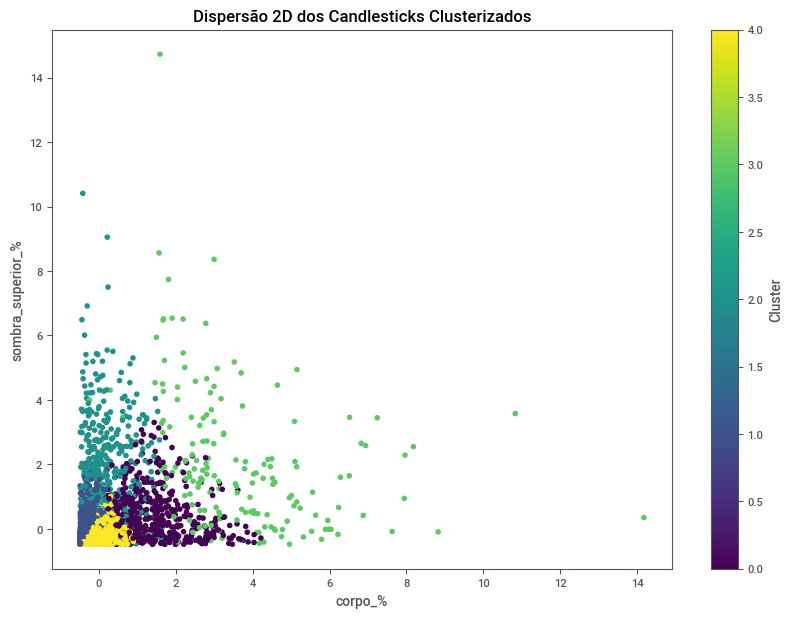

In [16]:
import matplotlib.pyplot as plt
# Gráfico de dispersão
plt.figure(figsize=(10, 7))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=df['Candle_Type'], cmap='viridis')
plt.title('Dispersão 2D dos Candlesticks Clusterizados')
plt.xlabel('corpo_%')
plt.ylabel('sombra_superior_%')
plt.colorbar(label='Cluster')
plt.show()

## **5. Avaliação de acordo com o intervalo de tempo.**

In [17]:
# Célula para solicitar o intervalo de tempo e mostrar ranking
# Solicitar ao usuário o intervalo de tempo desejado
start_date = input("Insira a data inicial (formato YYYY-MM-DD): ")
end_date = input("Insira a data final (formato YYYY-MM-DD): ")

# Filtrar o DataFrame para o intervalo de tempo especificado
test_candles = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Contar o número de candles em cada cluster
cluster_counts = test_candles['Candle_Type'].value_counts().sort_values(ascending=False)

# Exibir o ranking dos clusters
print(f"\nRanking dos clusters por frequência entre {start_date} e {end_date}:")
print(cluster_counts)

# Célula separada para plotar o gráfico
# Gráfico interativo de candlestick com classificação
fig = go.Figure(data=[go.Candlestick(x=test_candles['Date'],
                                       open=test_candles['Open'],
                                       high=test_candles['High'],
                                       low=test_candles['Low'],
                                       close=test_candles['Close'],
                                       name='Candlestick')])

# Cores para os clusters
colors = sns.color_palette("husl", n_colors=optimal_clusters)  # Gera cores distintas

# Adicionar os clusters sobre os candlesticks
unique_clusters = test_candles['Candle_Type'].unique()  # Obter classes presentes

for i in range(len(test_candles)):
    candle_type = test_candles['Candle_Type'].iloc[i]
    fig.add_trace(go.Scatter(
        x=[test_candles['Date'].iloc[i]],
        y=[test_candles['High'].iloc[i] + 2],  # Ajuste para que os marcadores fiquem acima do candle
        mode='markers',
        marker=dict(color=colors[candle_type], size=10),
        showlegend=False,
        hoverinfo='text',
        text=f'Tipo: {candle_type}'
    ))

# Adicionar legenda para cada tipo de candlestick presente
for candle_type in unique_clusters:
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(color=colors[candle_type], size=10),
        name=f'Tipo {candle_type}'
    ))

fig.update_layout(title='Candlesticks classificados',
                  xaxis_title='Data',
                  yaxis_title='Preço',
                  xaxis_rangeslider_visible=False)

fig.show()


Insira a data inicial (formato YYYY-MM-DD): 2021-01-01
Insira a data final (formato YYYY-MM-DD): 2021-02-01

Ranking dos clusters por frequência entre 2021-01-01 e 2021-02-01:
Candle_Type
2    10
3     6
0     4
Name: count, dtype: int64


## A avaliação da sequência de  candlesticks vai além da análise técnica. Também  há que se ter a compreensão do contexto do mercado.

## Os investidores precisam abordar o problema de modo reflexivo e também metódico. O mercado muda e isso afeta a análise de investimentos.

## Sem fazer contas e usar bibliotecas podemos traçar linhas conctando os topos e os fundos dos candlesticks e ter uma boa noção dos canais de alta e de baixa.

## A identificação do padrão ou do cluster a que pertence o candlestick ajuda, entre aspas, nas decisões de compra ou de venda, de um modo tanto mais ágil e dando uma boa noção do sentimento do mercado.
## Essa identificação dos padrões é essencial por exemplo em operações de day trade para minimizar riscos.